## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative



In [3]:
import os
import keras
from keras.datasets import cifar10

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
train, test = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    def __init__(self, valid_data=(x_test, y_test)):
        self.validation_data = valid_data
        
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_tp", "val_tn"]
        for i in record_items:
            try:
                if i not in self.params["metrics"]:
                    self.params["metrics"].append(i)
            except:
                self.params["metrics"] = i
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        val_tp = sum(y_true*y_pred)
        val_tn = sum((y_true==0) & (y_pred==0))
        
        logs["val_tp"] = val_tp
        logs["val_tn"] = val_tn
        
rec_tptn = Record_tp_tn()

In [10]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
49/49 [==============================] - 14s 252ms/step - loss: 2.2119 - accuracy: 0.2687 - val_loss: 2.1514 - val_accuracy: 0.1855 - val_tp: 0.0000e+00 - val_tn: 1000.0000
Epoch 2/25
49/49 [==============================] - 12s 255ms/step - loss: 1.7371 - accuracy: 0.3937 - val_loss: 1.9629 - val_accuracy: 0.3176 - val_tp: 1.0000 - val_tn: 1000.0000
Epoch 3/25
49/49 [==============================] - 12s 249ms/step - loss: 1.6156 - accuracy: 0.4329 - val_loss: 1.8102 - val_accuracy: 0.3816 - val_tp: 8.0000 - val_tn: 1000.0000
Epoch 4/25
49/49 [==============================] - 12s 239ms/step - loss: 1.5453 - accuracy: 0.4587 - val_loss: 1.6980 - val_accuracy: 0.4206 - val_tp: 124.0000 - val_tn: 1000.0000
Epoch 5/25
49/49 [==============================] - 11s 227ms/step - loss: 1.4914 - accuracy: 0.4787 - val_loss: 1.6260 - val_accuracy: 0.4423 - val_tp: 334.0000 - val_tn: 1000.0000
Epoch 6/25
49/49 [==============================] - 11s 217ms/step - loss: 1.4480 - accuracy

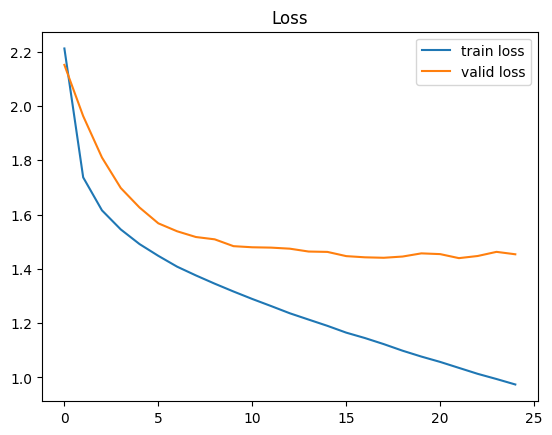

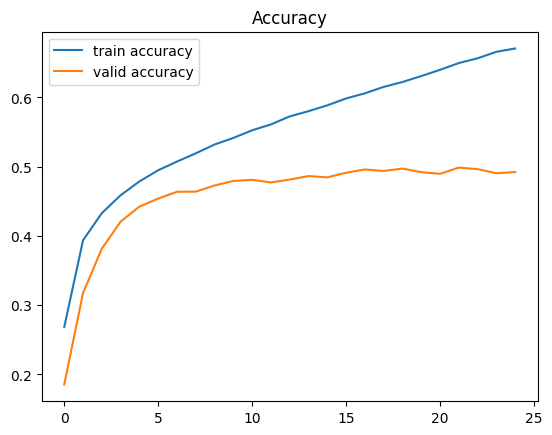

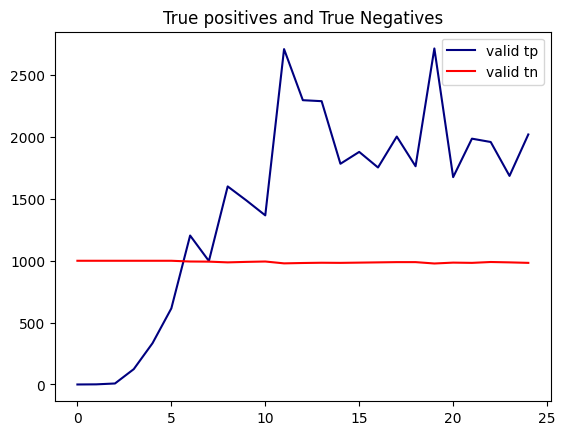

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()